In [1]:
import numpy as np
import os, sys
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ["KMP_WARNINGS"] = "FALSE" 
import time
# Import hessianlearn repository
sys.path.append( os.environ.get('HESSIANLEARN_PATH', "../../"))
from hessianlearn import *

sys.path.append('../hessianlearn/algorithms')
from varianceBasedNystrom import *
import matplotlib.pyplot as plt

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
settings = {}
settings['batch_size'] = 1000
settings['hess_batch_size'] = 10

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()


# Normalize the data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
# Reshape the data
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Instante the data object
data = Data([x_train,y_train],settings['batch_size'],\
            test_data = [x_test,y_test],hessian_batch_size = settings['hess_batch_size'])

In [3]:
encoding_dim = 32  
input_img = tf.keras.layers.Input(shape=(784,))
encoded = tf.keras.layers.Dense(encoding_dim, activation='softplus')(input_img)
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(encoded)
autoencoder = tf.keras.models.Model(input_img, decoded)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [4]:
problem = AutoencoderProblem(autoencoder,dtype=tf.float32)

settings['tikhonov_gamma'] = 0.0

regularization = L2Regularization(problem,gamma = settings['tikhonov_gamma'])

HLModel = HessianlearnModel(problem,regularization,data)
HLModel.settings['max_sweeps'] = 0.05

HLModel.fit()

set_weights = HLModel._best_weights


################################################################################
                      Size of configuration space:  50992                       
                          Size of training data: 60000                          
                    Approximate data cardinality needed: 65                     
################################################################################
                 Using low rank SFN optimizer with line search                  
                               Batch size = 1000                                
                            Hessian batch size = 10                             
                             Hessian low rank = 20                              
################################################################################
 sweeps    Loss     acc train   ||g||     Loss test  acc test   maxacc test  alpha       rank     
  0.00   2.3367e-01 -43.361% 3.1947e-02 2.3352e-01 -43.150% -43.150% 0.0000e+00          0 

In [5]:
def compute_Theta_slow(Q, apply_AA):
    r = Q.shape[1]
    m = len(apply_AA)
    Theta_true = np.zeros((r, r, m))
    for i in range(r):
        for j in range(r):
            for k in range(m):
                Theta_true[i,j,k] = np.dot(Q[:,i], apply_AA[k](Q[:,j]))
    return Theta_true

def compute_rayleigh_statistics_slow(U, apply_AA):
    m = len(apply_AA)
    r = U.shape[1]
    C = np.zeros((r, m))
    for k in range(m):
        for i in range(r):
            C[i,k] = np.dot(U[:,i], apply_AA[k](U[:,i]))

    all_mu = np.mean(C, axis=1)
    all_std = np.std(C, axis=1)
    return all_mu, all_std

In [6]:
class HessianWrapper:
    
    def __init__(self,hessian,data_dictionary):
        
        self._hessian = hessian
        self._data_dictionary = data_dictionary
        
        
    def __call__(self,x):
        return self._hessian(x,self._data_dictionary)

with tf.Session() as sess:
    random_state = np.random.RandomState(seed=0)
    
    sess.run(tf.global_variables_initializer())
    
    try:
        print(set_weights.keys())
        for layer_name in set_weights:
            autoencoder.get_layer(layer_name).set_weights(set_weights[layer_name])
    except:
        pass
    
    hessian = Hessian(problem = problem,sess = sess)
    n = hessian.dimension
    x_batch,_ = next(data.train)
    
    x_data = x_batch
    
    total_data = len(x_data)
    my_indices = np.arange(total_data).reshape((10,100))
    
    indices_list = [my_indices[:,k] for k in range(my_indices.shape[1])]
    
    data_dictionaries = [{problem.x : x_data[indices]} for indices in indices_list]
    

#     data_dictionaries = [{problem.x : np.expand_dims(x_datum,axis=0)} for x_datum in x_data]
    norms_of_data = []
    for dictionary in data_dictionaries:
        norms_of_data.append(np.linalg.norm(dictionary[problem.x]))
    
    apply_AA = [HessianWrapper(hessian,dictionary) for dictionary in data_dictionaries]
    
#     quads_true = []
#     for dictionary in data_dictionaries:
#         wHw = np.dot(w_hat,hessian(w_hat,dictionary))
#         quads_true.append(wHw)
        

#     quads = []
#     for apply_A in apply_AA:
#         quads.append(np.dot(w_hat,apply_A(w_hat)))
        

    if False:
        batch_r = 10
        Y = get_random_range_vectors(apply_AA, n, batch_r)

        Q,_ = np.linalg.qr(Y)
        Theta = compute_Theta(Q, apply_AA)
        print('Theta shape = ',Theta.shape)

        Theta_true = compute_Theta_slow(Q, apply_AA)
        err_Theta = np.linalg.norm(Theta - Theta_true)/np.linalg.norm(Theta_true)
        print('err_Theta=', err_Theta)
        dd, U, V = finish_computing_eigenvalue_decomposition(Q, Theta)

        all_mu, all_std = compute_rayleigh_statistics(Theta, V)

        all_mu_true, all_std_true = compute_rayleigh_statistics_slow(U, apply_AA)

        err_mu = np.linalg.norm(all_mu - all_mu_true)/np.linalg.norm(all_mu_true)
        err_std = np.linalg.norm(all_std - all_std_true)/np.linalg.norm(all_std_true)

        print('all_std = ',all_std)
        print('all_std_true = ',all_std_true)

        print('err_mu=', err_mu)
        print('err_std=', err_std)

    
    [dd_good, U_good, all_std_good],[dd_all,U_all,all_std] = variance_based_nystrom(apply_AA, n,max_bad_vectors=100)
    
    


dict_keys(['input_1', 'dense', 'dense_1'])
current_rank= 5 , num_bad_vectors= 0
current_rank= 15 , num_bad_vectors= 0
current_rank= 25 , num_bad_vectors= 0
current_rank= 32 , num_bad_vectors= 3
current_rank= 44 , num_bad_vectors= 1
current_rank= 51 , num_bad_vectors= 4
current_rank= 56 , num_bad_vectors= 9
current_rank= 57 , num_bad_vectors= 18
current_rank= 60 , num_bad_vectors= 25
current_rank= 64 , num_bad_vectors= 31
current_rank= 66 , num_bad_vectors= 39


In [7]:
dd_good

array([ 0.15434245,  0.15212753,  0.14872531,  0.14513151,  0.14439315,
        0.14262263,  0.14194889,  0.14085105,  0.12921347,  0.1288591 ,
        0.12254177,  0.11881617,  0.11668669,  0.11566443,  0.10953487,
        0.10570626,  0.09430571,  0.09328856,  0.09255398,  0.08891851,
        0.08692703,  0.08535097,  0.07942404,  0.07733366,  0.07538985,
        0.06683498, -0.0469632 , -0.04537073, -0.04412122, -0.03964585,
       -0.03896355, -0.03475649, -0.03445367, -0.03388209, -0.03284241,
       -0.03198868, -0.03102815, -0.0295025 , -0.0289437 , -0.0276152 ,
       -0.02726606, -0.02484857, -0.02422782, -0.02418634, -0.02370053,
       -0.01767801, -0.01664308, -0.01626918, -0.01546271, -0.01495184,
       -0.01427212, -0.01305666, -0.01240498, -0.01223882, -0.01097086,
       -0.01068901, -0.00983941, -0.00967619, -0.00883786, -0.00832944,
       -0.00729938, -0.00665645, -0.00639599, -0.0061586 , -0.00412066,
       -0.00363969])

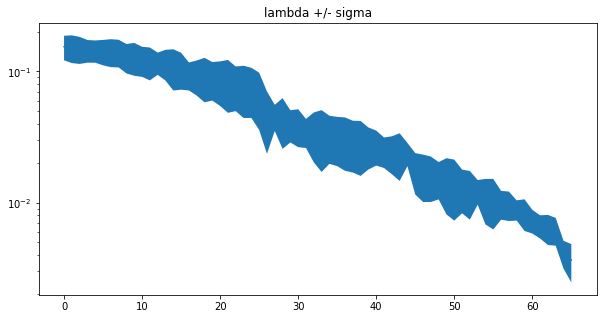

In [8]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.semilogy(np.arange(len(dd_good)),np.abs(dd_good))
ax.fill_between(np.arange(len(dd_good)),np.abs(dd_good)-all_std_good,np.abs(dd_good)+all_std_good)

plt.title('lambda +/- sigma')
plt.show()

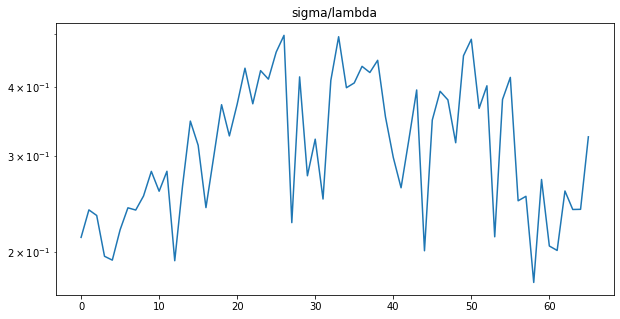

In [9]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.semilogy(np.arange(len(dd_good)),all_std_good/np.abs(dd_good))

plt.title('sigma/lambda')
plt.show()

In [10]:
|

SyntaxError: invalid syntax (<ipython-input-10-4b37ef281455>, line 1)